In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
import kornia as K
import kornia.feature as KF
from kornia.feature import laf_from_center_scale_ori as get_laf
from copy import deepcopy
import pydegensac
from extract_patches.core import extract_patches



In [2]:
# Let's download weights
#!wget https://github.com/ducha-aiki/affnet/raw/master/convertJIT/AffNetJIT.pt
#!wget https://github.com/ducha-aiki/affnet/raw/master/convertJIT/OriNetJIT.pt
#!wget https://github.com/ducha-aiki/affnet/raw/master/test-graf/img1.png
#!wget https://github.com/ducha-aiki/affnet/raw/master/test-graf/img6.png
#!wget https://github.com/ducha-aiki/affnet/raw/master/test-graf/H1to6p



In [3]:
#Define all required functions

def extimate_affine_shape(kpts, img, affnet, dev = torch.device('cpu'), ellipse=False):
    affnet = affnet.to(dev)
    affnet.eval()
    patches = np.array(extract_patches(kpts,
                                       cv2.cvtColor(img, cv2.COLOR_RGB2GRAY),
                                       32, 12., 'cv2')).astype(np.float32)
    bs = 128
    aff = np.zeros((len(patches), 3))
    for i in range(0, len(patches), bs):
        data_a = torch.from_numpy(patches[i:min(i + bs, len(patches)),  :, :]).unsqueeze(1).to(dev)
        with torch.no_grad():
            out_a = affnet(data_a)
            aff[i:i + bs] = out_a.view(-1, 3).cpu().detach().numpy()
    aff = torch.from_numpy(aff).to(dev)
    if ellipse:
        aff = aff.unsqueeze(1)
        laf = KF.ellipse_to_laf(torch.cat([torch.zeros_like(aff[...,:2]),aff], dim=2))
    else:
        aff2 = torch.cat([aff[:,0:1], torch.zeros_like(aff[:,0:1]), aff[:,1:2], aff[:,2:3]], dim=1).reshape(-1,2,2)
        laf = torch.cat([aff2,torch.zeros_like(aff2[:,:, 0:1])],dim=2).unsqueeze(1)
    
    ls = KF.get_laf_scale(laf)
    laf2 = KF.scale_laf(KF.make_upright(laf), 1./ls).squeeze(1)
    return laf2[:,:2,:2].detach().cpu().numpy()

def orinet_radians(inp, orinet):
    yx = orinet(inp)
    return torch.atan2(yx[:,0],yx[:,1])

def estimate_orientation(kpts, img, As, orinet, dev = torch.device('cpu')):
    orinet = orinet.to(dev)
    orinet.eval()
    patches = np.array(extract_patches((kpts,As),
                                       cv2.cvtColor(img, cv2.COLOR_RGB2GRAY),
                                       32, 12., 'cv2+A')).astype(np.float32)
    bs = 128
    aff = np.zeros((len(patches)))
    for i in range(0, len(patches), bs):
        data_a = torch.from_numpy(patches[i:min(i + bs, len(patches)),  :, :]).unsqueeze(1).to(dev)
        with torch.no_grad():
            out_a = orinet_radians(data_a, orinet)
            aff[i:i + bs] = out_a.cpu().detach().numpy()
    aff = np.rad2deg(-aff)
    return aff


def extract_descriptors(kpts, img, As, descnet, dev=torch.device('cpu')):
    descnet = descnet.to(dev)
    descnet.eval()
    patches = np.array(extract_patches((kpts,As),
                                       cv2.cvtColor(img, cv2.COLOR_RGB2GRAY),
                                       32, 12., 'cv2+A')).astype(np.float32)
    bs = 128
    desc = np.zeros((len(patches), 128))
    for i in range(0, len(patches), bs):
        data_a = torch.from_numpy(patches[i:min(i + bs, len(patches)),  :, :]).unsqueeze(1).to(dev)
        with torch.no_grad():
            out_a = descnet(data_a)
            desc[i:i + bs] = out_a.cpu().detach().numpy()
    return desc

def extract_sift_keypoints_upright(img, n_feat = 5000):
    sift = cv2.xfeatures2d.SIFT_create(2 * n_feat, 
            contrastThreshold=-10000, edgeThreshold=-10000)
    keypoints = sift.detect(img, None)
    response = np.array([kp.response for kp in keypoints])
    respSort = np.argsort(response)[::-1]
    kpts = [cv2.KeyPoint(keypoints[i].pt[0], keypoints[i].pt[1], keypoints[i].size, 0) for i in respSort]
    kpts_unique = []
    for x in kpts:
        if x not in kpts_unique:
            kpts_unique.append(x)
    return kpts_unique[:n_feat]

def detect_DoG_AffNet_OriNet_HardNet(img, nfeats = 5000, dev=torch.device('cpu')):
    hardnet = KF.HardNet(True).to(dev).eval()

    affnet = torch.jit.load('AffNetJIT.pt').to(dev).eval()
    affnet.eval()

    orinet = torch.jit.load('OriNetJIT.pt').to(dev).eval()
    orinet.eval()

    kpts = extract_sift_keypoints_upright(img, nfeats)
    As = extimate_affine_shape(kpts, img, affnet, dev)
    ori = estimate_orientation(kpts, img, As, orinet, dev)
    kpts_new = [cv2.KeyPoint(x.pt[0], x.pt[1], x.size, ang) for x, ang in zip(kpts,ori)]
    descs = extract_descriptors(kpts_new, img, As, hardnet, dev)
    return kpts_new, descs, As

def detect_DoGAffine_OriNet_HardNet(img, nfeats = 5000, dev=torch.device('cpu')):
    hardnet = KF.HardNet(True).to(dev).eval()

    affnet = KF.PatchAffineShapeEstimator(32).to(dev)
    
    orinet = torch.jit.load('OriNetJIT.pt').to(dev).eval()
    orinet.eval()

    kpts = extract_sift_keypoints_upright(img, nfeats)
    As = extimate_affine_shape(kpts, img, affnet, dev, ellipse=True)
    ori = estimate_orientation(kpts, img, As, orinet, dev)
    kpts_new = [cv2.KeyPoint(x.pt[0], x.pt[1], x.size, ang) for x, ang in zip(kpts,ori)]
    descs = extract_descriptors(kpts_new, img, As, hardnet, dev)
    return kpts_new, descs, As


def detect_DoG_OriNet_HardNet(img, nfeats = 5000, dev=torch.device('cpu')):
    hardnet = KF.HardNet(True).to(dev).eval()

    orinet = torch.jit.load('OriNetJIT.pt').to(dev).eval()
    orinet.eval()

    kpts = extract_sift_keypoints_upright(img, nfeats)
    As = torch.eye(2).view(1,2,2).expand(len(kpts), 2, 2).numpy()
    ori = estimate_orientation(kpts, img, As, orinet, dev)
    kpts_new = [cv2.KeyPoint(x.pt[0], x.pt[1], x.size, ang) for x, ang in zip(kpts,ori)]
    descs = extract_descriptors(kpts_new, img, As, hardnet, dev)
    return kpts_new, descs, As

def laf_from_opencv_kpts(kpts, As,  mrSize=6.0, device=torch.device('cpu')):
    N = len(kpts)
    xy = torch.tensor([(x.pt[0], x.pt[1]) for x in kpts ], device=device, dtype=torch.float).view(1, N, 2)
    scales = torch.tensor([(mrSize * x.size) for x in kpts ], device=device, dtype=torch.float).view(1, N, 1, 1)
    angles = torch.tensor([(-x.angle) for x in kpts ], device=device, dtype=torch.float).view(1, N, 1)
    laf = get_laf(xy, scales, angles).view(-1, 2,3)
    laf[:, :2,:2] = torch.bmm(laf[:, :2,:2], torch.from_numpy(As).to(device).float())
    return laf.reshape(1,-1,2,3)

def match_snn(desc1, desc2, snn_th = 0.8):
    index_params = dict(algorithm=1, trees=4)
    search_params = dict(checks=128)  # or pass empty dictionary
    matcher = cv2.FlannBasedMatcher(index_params, search_params)
    matches = matcher.knnMatch(desc1.astype(np.float32), desc2.astype(np.float32), k=2)
    good_matches = []
    for m,n in matches:
        if m.distance < snn_th * n.distance:
            good_matches.append(m)
    return good_matches

def ransac_validate(tentatives, kpts1, kpts2, inl_th = 1.0):
    src_pts = np.float32([ kpts1[m.queryIdx].pt for m in tentatives ]).reshape(-1,2)
    dst_pts = np.float32([ kpts2[m.trainIdx].pt for m in tentatives ]).reshape(-1,2)
    H, mask = pydegensac.findHomography(src_pts, dst_pts, inl_th, 0.99, 50000)
    #F, mask = pydegensac.findFundamentalMatrix(src_pts, dst_pts,0.5)
    print (deepcopy(mask).astype(np.float32).sum(), 'inliers found')
    return H, mask


def decolorize(img):
    return  cv2.cvtColor(cv2.cvtColor(img,cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2RGB)

def draw_matches(kps1, kps2, As1, As2, tentatives, inl_mask, img1, img2, H_gt):
    matchesMask = inl_mask.ravel().tolist()
    tentatives_idxs = np.array([[m.queryIdx, m.trainIdx] for m in tentatives])
    h,w,ch = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts, H)
    #Ground truth transformation
    dst_GT = cv2.perspectiveTransform(pts, H_gt)
    img2_tr = cv2.polylines(decolorize(img2),[np.int32(dst)],True,(0,0,255),3, cv2.LINE_AA)
    img2_tr = cv2.polylines(deepcopy(img2_tr),[np.int32(dst_GT)],True,(0,255,0),3, cv2.LINE_AA)
    draw_params = dict(matchColor = (255,255,0), # draw matches in yellow color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = cv2.DRAW_MATCHES_FLAGS_DEFAULT+2)
    lafs1 = laf_from_opencv_kpts(kps1, As1, 6.0)
    lafs2 = laf_from_opencv_kpts(kps2, As2, 6.0)
    x1,y1 = KF.laf.get_laf_pts_to_draw(lafs1[:,tentatives_idxs[matchesMask,0]], 0)
    x2,y2 = KF.laf.get_laf_pts_to_draw(lafs2[:,tentatives_idxs[matchesMask,1]], 0)
    plt.figure(figsize=(20,16))
    img_out = cv2.drawMatches(decolorize(img1),
                              kps1,
                              img2_tr,
                              kps2,
                              tentatives,None,**draw_params)
    plt.imshow(img_out)
    plt.plot(x1, y1, 'y')
    plt.plot(x2+w, y2, 'y')
    
    return 

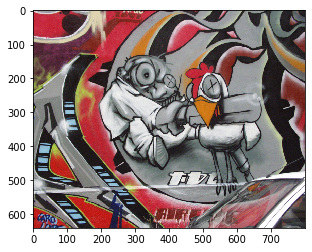

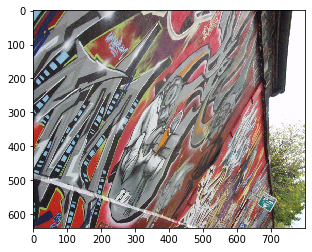

In [4]:
img1 = cv2.cvtColor(cv2.imread('img1.png'), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('img6.png'), cv2.COLOR_BGR2RGB)
Hgt = np.loadtxt('H1to6p')

plt.imshow(img1)
plt.figure()
plt.imshow(img2)

## DoG-AffNet-OriNet-HardNet

31.0 inliers found


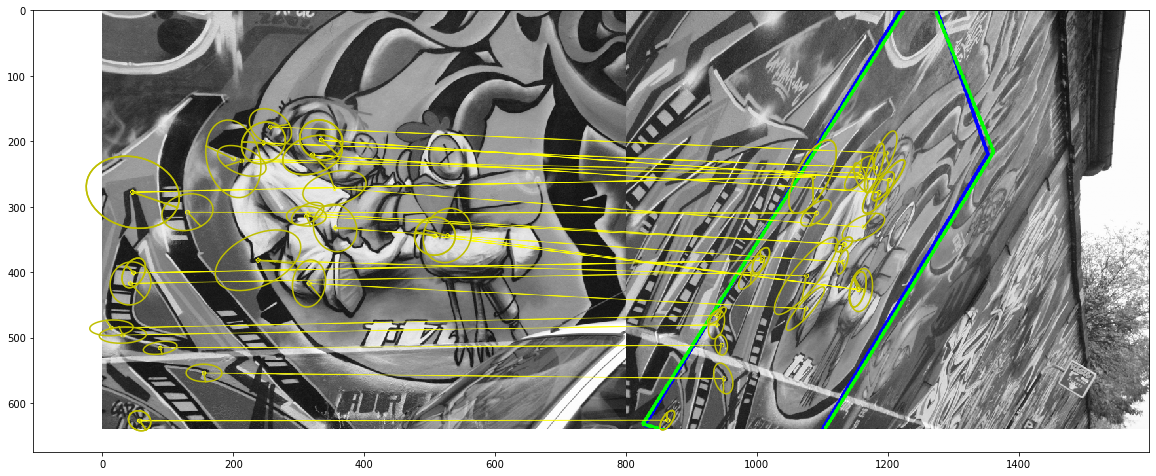

In [5]:
dev = torch.device('cpu')
#dev = torch.device('cuda')

NFEATS = 5000
kpts1, descs1, As1 = detect_DoG_AffNet_OriNet_HardNet(img1, NFEATS, dev)
kpts2, descs2, As2 = detect_DoG_AffNet_OriNet_HardNet(img2, NFEATS, dev)

tentatives = match_snn(descs1, descs2, 0.85)
H, inl_mask = ransac_validate(tentatives, kpts1, kpts2, 2.0)
draw_matches(kpts1, kpts2, As1, As2, tentatives, inl_mask, img1, img2, Hgt)

## DoG-Affine-OriNet-HardNet

15.0 inliers found


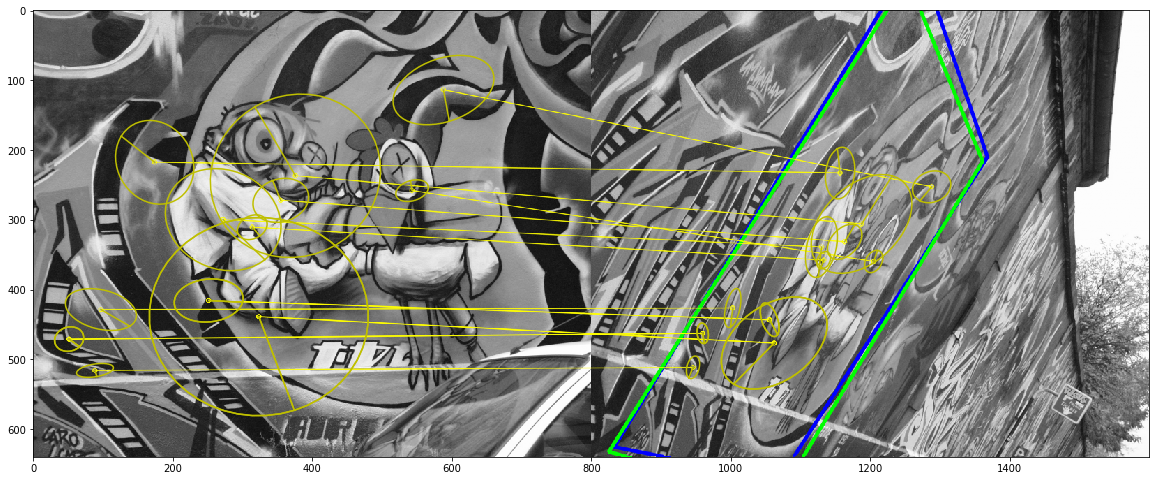

In [6]:
dev = torch.device('cpu')
#dev = torch.device('cuda')

NFEATS = 5000
kpts1, descs1, As1 = detect_DoGAffine_OriNet_HardNet(img1, NFEATS, dev)
kpts2, descs2, As2 = detect_DoGAffine_OriNet_HardNet(img2, NFEATS, dev)

tentatives = match_snn(descs1, descs2, 0.85)
H, inl_mask = ransac_validate(tentatives, kpts1, kpts2, 2.0)
draw_matches(kpts1, kpts2, As1, As2, tentatives, inl_mask, img1, img2, Hgt)

## DoG-OriNet-HardNet

25.0 inliers found


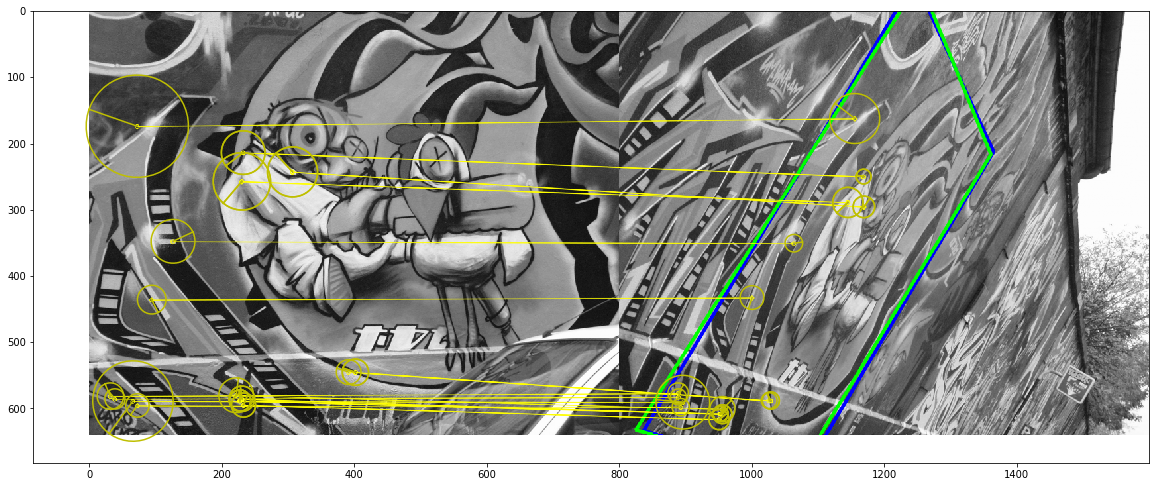

In [7]:
dev = torch.device('cpu')
#dev = torch.device('cuda')

NFEATS = 5000
kpts1, descs1, As1 = detect_DoG_OriNet_HardNet(img1, NFEATS, dev)
kpts2, descs2, As2 = detect_DoG_OriNet_HardNet(img2, NFEATS, dev)

tentatives = match_snn(descs1, descs2, 0.85)
H, inl_mask = ransac_validate(tentatives, kpts1, kpts2, 2.0)
draw_matches(kpts1, kpts2, As1, As2, tentatives, inl_mask, img1, img2, Hgt)